In [105]:
import pandas as pd
import numpy as np
import re
# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
# Gensim
import gensim
from gensim.utils import simple_preprocess
# NLTK
import nltk
from nltk.corpus import stopwords
from collections import Counter
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
# from wordcloud import WordCloud,ImageColorGenerator
# from PIL import Image
# import urllib
import requests
%matplotlib inline

In [114]:
df_full = pd.read_csv("congress-tweets.csv", encoding='utf-8')
len(df_full)
df_full.head()

,tweet,author,party,chamber,congress,retweet
0,VIDEO: Today's press conference w/ @SenBobCork...,"Alexander, Lamar (TN)",D,H,112,0
1,Will hold press conference in the Capitol's Ra...,"Alexander, Lamar (TN)",D,H,112,0
2,"""Major threats to our research universities"" O...","Alexander, Lamar (TN)",D,H,112,1
3,".@SenAlexander The Wind #PTC is ""a brazen flee...","Alexander, Lamar (TN)",D,H,112,1
4,VIDEO: Sen. Alexander on passing of Sen. @Dani...,"Alexander, Lamar (TN)",D,H,112,0


In [34]:
df = pd.read_hdf('sampled_df.h5', index_col=0)

In [35]:
# pre processing function of the tweets
# just combined it all into one function so it is less messy

def pre_process_df(df):
    df['tidy_tweet'] = df['tweet'].str.lower()
    # REMOVE '@USER'
    df['tidy_tweet'] = np.vectorize(remove_users)(df['tweet'],"@ [\w]*", "@[\w]*")
    print('Users Removed from Tweets')
    # REMOVE HASHTAGS
    df['tidy_tweet'] = np.vectorize(remove_hashtags)(df['tidy_tweet'], "# [\w]*", "#[\w]*")
    print('Hashtags Removed from Tweets')
    # REMOVE LINKS
    df['tidy_tweet'] = np.vectorize(remove_links)(df['tidy_tweet'])
    print('Links Removed from Tweets')
    # EXTRACT TWEET DATE
    df['date'] = df['tweet'].str.extract(r"([A-Z][a-z]+\s\d+,\s\d+)\s*$")
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    print('Dates Extracted')
    # REMOVE Punctuations, Numbers, and Special Characters
    df['tidy_tweet'] = df['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")
    print('Punctuation, Numbers, and Special Characters Removed from Tweets')
    # TOKENIZATION
    df['tidy_tweet_tokens'] = list(tokenize(df['tidy_tweet']))
    print('Tokenized')
    # REMOVE STOPWORDS
    df['tokens_no_stop'] = remove_stopwords(df['tidy_tweet_tokens'])
    print('Stop Words Removed from Tweets')
    # DROP EMPTY TWEETS
    df = df[df['tokens_no_stop'].apply(lambda x: len(x)) > 0]
    print('Empty Tweets Dropped')
    print('DataFrame Finished')
    return df
    
def remove_users(tweet, pattern1, pattern2):
    r = re.findall(pattern1, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
  
    r = re.findall(pattern2, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
    return tweet

def remove_hashtags(tweet, pattern1, pattern2):
    r = re.findall(pattern1, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
    
    r = re.findall(pattern2, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
    return tweet

def remove_links(tweet):
    tweet_no_link = re.sub(r"http\S+", "", tweet)
    return tweet_no_link

def tokenize(tweet):
    for word in tweet:
        yield(gensim.utils.simple_preprocess(str(word), deacc=True))
        
def remove_stopwords(tweets):
    # Prepare Stop Words
    stop_words = stopwords.words('english')
    stop_words.extend(['from', 'https', 'twitter', 'religions', 'pic','twitt','today','will','thank', 'thanks',
                      'jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec', 'great', 'new', 'day', 'rt',
                      'th', 'morning', 'week', 'com', 'net'])
    #words to remove from stopwords
    remove_words = ['we','our','ours','ourselves']
    stop_words = [e for e in stop_words if e not in remove_words]
    return [[word for word in simple_preprocess(str(tweet)) if word not in stop_words] for tweet in tweets]

In [36]:
df = pre_process_df(tweets)

Users Removed from Tweets
Hashtags Removed from Tweets
Links Removed from Tweets
Dates Extracted


/var/folders/39/kmnxq3052lj44c_nv8qgh6y80000gn/T/ipykernel_78836/3824681370.py:20: FutureWarning: The default value of regex will change from True to False in a future version.
  df['tidy_tweet'] = df['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")


Punctuation, Numbers, and Special Characters Removed from Tweets
Tokenized
Stop Words Removed from Tweets
Empty Tweets Dropped
DataFrame Finished


In [37]:
print(df.shape)
print(df.head())

dems = df[df['party'] == 'D']
reps = df[df['party'] == 'R']

tokens = np.concatenate(df['tokens_no_stop'].values)
dem_tokens = np.concatenate(dems['tokens_no_stop'].values)
rep_tokens = np.concatenate(reps['tokens_no_stop'].values)

(879316, 10)
                                               tweet                 author  \
0  VIDEO: Today's press conference w/ @SenBobCork...  Alexander, Lamar (TN)   
1  Will hold press conference in the Capitol's Ra...  Alexander, Lamar (TN)   
2  "Major threats to our research universities" O...  Alexander, Lamar (TN)   
3  .@SenAlexander The Wind #PTC is "a brazen flee...  Alexander, Lamar (TN)   
4  VIDEO: Sen. Alexander on passing of Sen. @Dani...  Alexander, Lamar (TN)   

  party chamber  congress  retweet  \
0     D       H       112        0   
1     D       H       112        0   
2     D       H       112        1   
3     D       H       112        1   
4     D       H       112        0   

                                          tidy_tweet       date  \
0  VIDEO  Today s press conference w   on the  is... 2012-12-28   
1  Will hold press conference in the Capitol s Ra... 2012-12-28   
2   Major threats to our research universities  O... 2012-12-19   
3    The Wind  

In [120]:
print('total', len(tokens), 'dem tokens', len(dem_tokens), 'rep tokens', len(rep_tokens))
print('dem', (len(dem_tokens)/len(tokens)), 'rep', (len(rep_tokens)/len(tokens)))

total 7521269 dem tokens 3202017 rep tokens 4319252
dem 0.4257282913295615 rep 0.5742717086704384


In [125]:
negwords = pd.read_csv("negativewords.csv").squeeze('columns')
negwords.head()

0       2-faces
1      abnormal
2       abolish
3    abominable
4    abominably
Name: 2-faced, dtype: object

In [126]:
#tweets with negative words
neg_mask = df['tokens_no_stop'].apply(lambda x: len(set(negwords) & set(x)) != 0)
df_neg = df[neg_mask]



In [127]:
print(df_neg.head())

                                                tweet                 author  \
2   "Major threats to our research universities" O...  Alexander, Lamar (TN)   
3   .@SenAlexander The Wind #PTC is "a brazen flee...  Alexander, Lamar (TN)   
10  .@SenAlexander Difficulties Japan is facing af...  Alexander, Lamar (TN)   
15  Teaming up with @SenAlexander to help ensure T...  Alexander, Lamar (TN)   
16  Sen. Alexander calls meningitis outbreak “a ni...  Alexander, Lamar (TN)   

   party chamber  congress  retweet  \
2      D       H       112        1   
3      D       H       112        1   
10     D       H       112        1   
15     D       H       112        1   
16     D       H       112        0   

                                           tidy_tweet       date  \
2    Major threats to our research universities  O... 2012-12-19   
3     The Wind  is  a brazen fleecing of the taxpa... 2012-12-19   
10    Difficulties Japan is facing after closing i... 2012-12-05   
15  Teaming 

In [ ]:
df_neg.groupby('party')['tweet'].count() / df.groupby('party')['tweet'].count()

In [107]:
#frequency of positive words in tweets
neg_arr = np.array(negwords)
dic = {}

for w in neg_arr:
    if w not in dic:
        dic[w] = 1
    for tweet in df_neg['tidy_tweet_tokens']:
        if w in tweet:
            dic[w] += 1
            
neg_word_keys = dic.keys()
nums = dic.values()

neg_word_counts = pd.DataFrame(list(zip(neg_word_keys, nums)), columns = ["Word", "Frequency"])
print(neg_word_counts)

            Word  Frequency
0        2-faces          1
1       abnormal          1
2        abolish          1
3     abominable          1
4     abominably          1
...          ...        ...
4777        zaps          1
4778      zealot          1
4779     zealous          1
4780   zealously          1
4781      zombie          1

[4782 rows x 2 columns]


In [110]:
#top 10 words
top_ten = neg_word_counts.nlargest(10, 'Frequency')
print(top_ten)

                Word  Frequency
4685          wasted          9
1564          failed          8
660        confusion          5
2817             mar          4
257         bankrupt          3
1114  disappointment          3
1567         failure          3
1947            hard          3
2542         ironies          3
3336         poorest          3


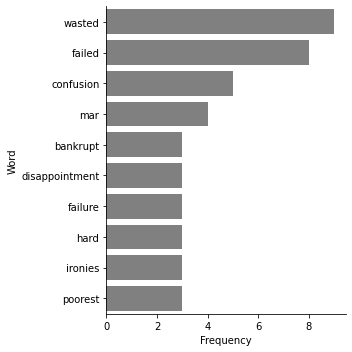

In [128]:
import seaborn as sns
sns.catplot(data=top_ten, x='Frequency', y='Word', kind='bar', color='gray')

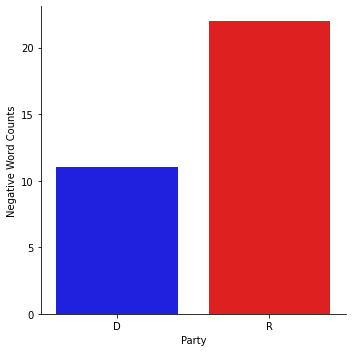

In [129]:
counts_party = df_pos.groupby('party')['tweet'].count().reset_index()
b = sns.catplot(data=counts_party, x='party', y='tweet', kind='bar', color='gray',
               palette=sns.color_palette(['blue', 'red']))
b.set_axis_labels("Party", "Negative Word Counts")

In [57]:
dem_pos = df_pos[df_pos['party'] == 'D']
rep_pos = df_pos[df_pos['party'] == 'R']

In [47]:
pos_tokens = np.concatenate(df_pos['tokens_no_stop'].values)
pos_dem_tokens = np.concatenate(dem_pos['tokens_no_stop'].values)
pos_rep_tokens = np.concatenate(rep_pos['tokens_no_stop'].values)